In [1]:
import json
import os
from collections import defaultdict
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from pycocotools import mask
from PIL import Image
from rasterio.plot import show
import matplotlib.pyplot as plt
import base64

First attempt at making this into a pytorch dataset. I'm sure there are off-the-shelf solutions for this, but I'm too lazy to look it up right now.

Biggest issue: annotations are not in a format that PyTorch dataloaders can process. So this only works when you grab one example at a time.

In [2]:
class CocoLoader(Dataset):
    def __init__(self, annotation_file, image_dir, max_masks=64):
        self.annotation_file = annotation_file
        self.image_dir = image_dir
        self.max_masks = max_masks
        with open(self.annotation_file, 'r') as f:
            self.data = json.load(f)
        self.index_annotations()
        self.transform = transforms.ToTensor()

    def index_annotations(self):
        self.images = {}
        self.imgToAnns = defaultdict(list)
        for image in self.data['images']:
            self.images[image['id']] = image
        
        self.annotations = {}
        for ann in self.data['annotations']:
            self.annotations[ann['id']] = ann
            self.imgToAnns[ann['image_id']].append(ann)
            self.imgToAnns[ann['image_id']] = sorted(self.imgToAnns[ann['image_id']], key=lambda x: x['area'], reverse=True)
        
        self.categories = {}
        for cat in self.data['categories']:
            self.categories[cat['id']] = cat

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_record = self.images[idx]
        image = Image.open(os.path.join(self.image_dir, image_record['file_name']))
        annotations = self.imgToAnns[idx]
        return (self.transform(image), annotations)



In [49]:
dl = CocoLoader('./data/chunked/coco_quebec.json', './data/chunked/images/')
print([(k,v) for k,v in dl.images.items() if '1fd7daeb-b2e5-48e1-bf45-7905548a211a' in v['file_name']])

[(52, {'id': 52, 'width': 1280, 'height': 960, 'file_name': '1fd7daeb-b2e5-48e1-bf45-7905548a211a.tif', 'date_captured': '2022-06-01'})]


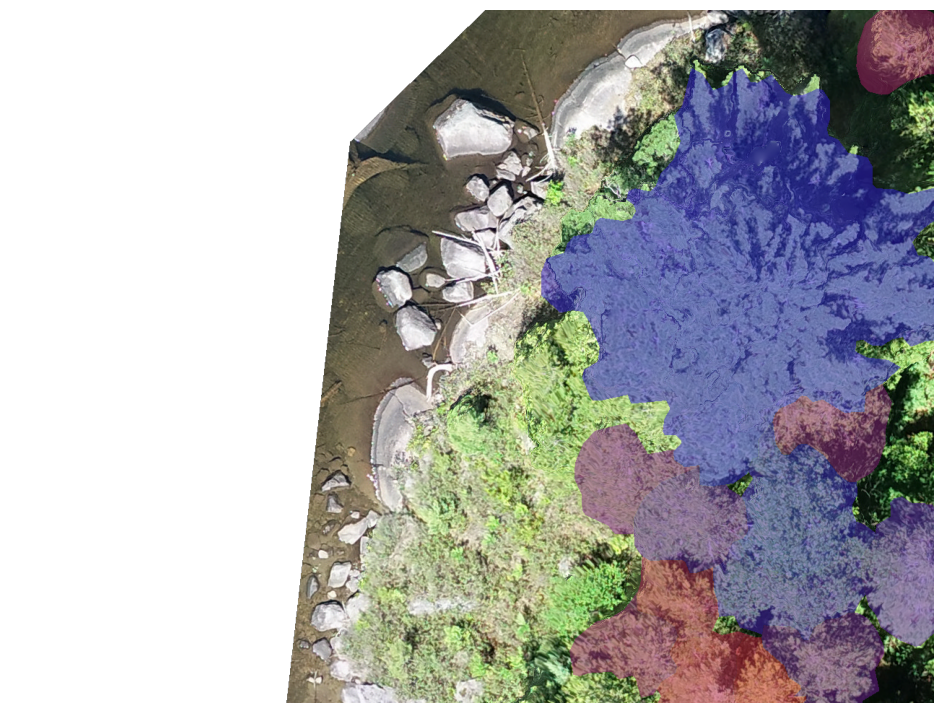

In [50]:

img, anns = dl.__getitem__(52)

img = img.numpy().transpose((1,2,0))
img = (img * 255).astype(np.uint8)
masks = []
for an in anns:
    # decode from JSON string to bytes
    an['segmentation']['counts'] = base64.b64decode(an['segmentation']['counts'].encode('utf-8'))
    masks.append(mask.decode(an['segmentation']))

plt.figure(figsize=(12,9))
plt.imshow(img)

reds = [i for i in range(50, 220, (220-50)//len(masks))]
blues = reds.copy()
blues.reverse()

for i, m in enumerate(masks):
    mplot = np.zeros(img.shape, dtype=np.uint8)
    mplot[:,:,3] = np.where(m == 1, 255,0)
    mplot[:,:,0] = reds[i]
    mplot[:,:,1] = 30
    mplot[:,:,2] = blues[i]
    plt.imshow(mplot, alpha=0.5)  # Adjust alpha for transparency

# Display the result
plt.axis('off')
plt.show()